 Copyright 2019 The RecSim Authors.

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Developing an Environment

In the [last tutorial](RecSim_Overview.ipynb), we went over the high-level ideas and basics of using RecSim for training and evaluation of a recommender agent. While agent development is an important use case of RecSim, simulation environments are first-class citizens too! The simulation of novel and difficult recommendation system tasks is important in and of itself. In this tutorial we will break a RecSim environment down into its basic components. 
![Detailed view of RecSim](https://github.com/google-research/recsim/blob/master/recsim/colab/figures/simulator.png?raw=true)

The green and blue blocks in the above diagram constitute the classes that need to be implemented within a RecSim environment. The goal of this tutorial is to explain the purpose of these blocks and how they come together in a simulation.  In the process, we will go over an example end-to-end implementation.



# Overview

A single step of a RecSim simulation can be summarized roughly as follows:


1.   the document database provides a corpus of *D* documents to the recommender. This could be a different set at each step (e.g., sampled, or produced by some "candidate generation" process), or fixed throughout the simulation. Each document is represented by a list of features. In a fully observable situation, the recommender observes all features of each document that impact the user's state and choice of document (and other aspects of the user's response), but this need not be the case in general. (In fact, most interesting scenarios involve latent features.)
2.   The recommender observes the *D* documents (and their features) together with the user's response to the last recommendation. It then makes a selection (possibly ordered) of *k* documents and presents them to the user. The ordering may or may not impact the user choice or user state, depending on our simulation goals.
3.   The user examines the list of documents and makes a choice of one document. Note that not consuming any of the documents is also a valid choice. This leads to a transition in the user's state. Finally the user emits an observation, which the recommender observes at the next iteration. The observation generally includes (noisy) information about the user's reaction to the content and potentially clues about the user's latent state. Typically, the user's state is not fully revealed. 

If we examine at the diagram above carefully, we notice that the flow of information along arcs is acyclic---a RecSim environment is a dynamic Bayesian network (DBN), where the various boxes represent conditional probability distributions. We will now define a simple simulation problem and implement it. 

#Simulation Scenario: Choc vs. Kale

Consider the following scenario: the elements of our corpus are characterized by the degree to which they are *nutritious* vs. *regretful*---we some tongue-in-cheek refer to nutritious items as ``kale'' and regretful items as ''chocalate.'' Regretful documents generate very high engagement among users, yet long-term over-consumption  of such documents leads to a decrease in user satisfaction. On the other hand, nutritious documents generate relatively low engagement, but their consumption leads to long-term satisfaction. We will model this document property as a continuous feature taking values in the [0,1]-interval, calling it the Kaleness scale. A document scoring 1 is fully nutritious, while a document scoring 0 is fully regretful. 

A user's latent state consists of a 1-dimensional *satisfaction* variable. Each time a more "kaley" document is consumed, that variable tends to increase, and conversely, a chocolatey document tends to decrease satisfaction. Upon consumption of a document, the user emits some (stochastic) measure of engagement (say, the watch-time of a video). The magnitude of the expected engagement is proportional to the user's satisfaction and inversely proportional to the kaleness of the video. 

Thus, the goal is to find the optimal mix of chocolatey and kaley items so as to keep the user engaged over a long period of time. 

We will discuss the particular functional forms for the various components as we go along.

In [0]:
# @title Install
!pip install --upgrade --no-cache-dir recsim

In [0]:
#@title Generic imports
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats

The main imports we use from RecSim are user and document -- they provide the abstract classes needed to instantiate all components of the environment.

In [0]:
#@title RecSim imports
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

#A Document Model

A RecSim document is a class inheriting from recsim.document.AbstractDocument. It serves as the main unit of exchange between the document model, agent, and user. A document class implementation is essentially a container for the  unobservable and observable features of the underlying document. The base class requires the implementation of an observation_space() static method, declaring the format of the document observable features as an OpenAI gym space, and a create_observation function, which returns a realization of said space. Also, each document must have a unique integer ID.

In our case, documents are have only one feature, namely, their kaleness value, represented as a 1-dimensional spaces.Box (i.e., numpy array of size 1).

In [0]:
class LTSDocument(document.AbstractDocument):
  def __init__(self, doc_id, kaleness):
    self.kaleness = kaleness
    # doc_id is an integer representing the unique ID of this document
    super(LTSDocument, self).__init__(doc_id)

  def create_observation(self):
    return np.array([self.kaleness])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
  def __str__(self):
    return "Document {} with kaleness {}.".format(self._doc_id, self.kaleness)

Having implemented a document template, we now need a document sampler. A document sampler is a generative distribution for documents, which will get invoked to regenerate the corpus either after every step or after every session  (depending on runner_lib settings). The object of interest is the sample_document() function required by the base class. It must return a document sampled from our desired distribution. In our case, it returns a document with a kaleness score sampled from a uniform distribution.

In [0]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
  def __init__(self, doc_ctor=LTSDocument, **kwargs):
    super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
    self._doc_count = 0

  def sample_document(self):
    doc_features = {}
    doc_features['doc_id'] = self._doc_count
    doc_features['kaleness'] = self._rng.random_sample()
    self._doc_count += 1
    return self._doc_ctor(**doc_features)

With this we can now simulate documents.

In [0]:
sampler = LTSDocumentSampler()
for i in range(5): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Document 0 with kaleness 0.5488135039273248.
Document 1 with kaleness 0.7151893663724195.
Document 2 with kaleness 0.6027633760716439.
Document 3 with kaleness 0.5448831829968969.
Document 4 with kaleness 0.4236547993389047.
Documents have observation space: Box(1,) 
An example realization is:  [0.64589411]


In RecSim, we never have to manually sample documents---the simulator does this, so a document sampler is a required argument of the simulation.

#A User Model

We now have a reasonable document model, so we turn towards the user model to complete the environment. A user model consists of the following components:
* a user state,
* a user sampler (a distribution over the starting state of users), 
* a user state transition model, and
* a user response.

Our user model for this tutorial is as follows:
* each user has a feature called net kale exposure ($\text{nke}_t$), and satisfaction ($\text{sat}_t$). They are related via the logistic function to reflect the fact that satisfaction cannot be unbounded. Namely,
$$\text{sat}_t = \sigma(\tau\cdot\text{nke}_t),$$
where $\tau$ is a user-specific sensitivity parameter. Satisfaction and net kale exposure are bijectively related to each other, so only one is needed to keep track of state.
* Given a slate $S$, the user chooses an item based on a multinomial logit choice model with the items' chocolateness as features: $p(\text{user chooses }d_i \text{ from slate }S) \sim e^{1-\mathrm{kaleness}(d_i)}$ (since chocolatey documents are more clicky).
* Once the user chooses a document, the net kale exposure evolves as
$$\text{nke}_{t+1} = \beta \cdot \text{nke}_t + 2(k_d - 1/2) + {\cal N}(0, \eta),$$
where $\beta$ is some user-specific memory discount (forgetting factor), $k_d$ is the kaleness of the chosen document and $\eta$ is some noise standard deviation. 
* Finally, the user engages with the chosen content for $s_d$ seconds, where $s_d$ is drawn according to
$$s_d\sim\log{\cal N}(k_d\mu_k + (1-k_d)\mu_c, k_d\sigma_k + (1-k_d)\sigma_c),$$
i.e. a log-normal distribution with parameters linearly interpolating between the pure kale response $(\mu_k, \sigma_k)$ and the pure choc response $(\mu_c, \sigma_c)$.

Thus, a user state is defined by the tuple $(\text{sat}, \tau, \beta, \eta, \mu_k, \sigma_k, \mu_c, \sigma_c).$ The satisfaction variable is the only dynamic part of the state, whereas the other parameters define the user and are static. Technically, we are not required to keep these as part of the state as opposed to hardcoding them, however, it enables us to, say, sample users with different properties.



## User state and user sampler 
Similarly to documents, we begin by implementing a user state class, i.e. a class that acts as a container for all these parameters. Similarly to AbstractDocument, AbstractUserState requires us to implement an observation_space() and create_observations(). These are used to feed partial (or complete) information about the user's state to the agent at every iteration. 

We also maintain a time budget, which will cap the session length. In this scenario, the session length will be fixed to some constant, so it's not worth being explicit with our time budget modeling, but one can definitely consider this as part of the state and do more interesting thigs with it. 

Finally we will implement a score_document method, that maps a document to a non-negative real number. This significance of this will become clear shortly. 

In [0]:
class LTSUserState(user.AbstractUserState):
  def __init__(self, memory_discount, sensitivity, innovation_stddev,
               choc_mean, choc_stddev, kale_mean, kale_stddev,
               net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
              ):
    ## Transition model parameters
    ##############################
    self.memory_discount = memory_discount
    self.sensitivity = sensitivity
    self.innovation_stddev = innovation_stddev

    ## Engagement parameters
    self.choc_mean = choc_mean
    self.choc_stddev = choc_stddev
    self.kale_mean = kale_mean
    self.kale_stddev = kale_stddev

    ## State variables
    ##############################
    self.net_kaleness_exposure = net_kaleness_exposure
    self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
    self.time_budget = time_budget

    # Noise
    self._observation_noise = observation_noise_stddev

  def create_observation(self):
    """User's state is not observable."""
    clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                           1.0 / (1.0 * self._observation_noise))
    noise = stats.truncnorm(
        clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
    noisy_sat = self.satisfaction + noise
    return np.array([noisy_sat,])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
  
  # scoring function for use in the choice model -- the user is more likely to
  # click on more chocolatey content.
  def score_document(self, doc_obs):
    return 1 - doc_obs

Also similarly to our document model, we have need a starting state sampler, that sets the starting user state for every session. For this tutoral, we will just sample the starting $\text{nke}_0$ and keep all the static parameters the same, meaning that we essentially deal with the same user at different levels of satisfaction. One can, of course, extend this easily to generate also users with different parameters by randomizing the values. 

Observe that if $\eta = 0$, $\text{nke}$ would be bounded in the interval $\left[-\frac{1}{1-\beta}, \ldots, \frac{1}{1-\beta} \right]$ at all times, so as starting distribution we just sample uniformly from that range. Sampling code has to be implemented in sample_user(), as required by the base class.

In [0]:
class LTSStaticUserSampler(user.AbstractUserSampler):
  _state_parameters = None

  def __init__(self,
               user_ctor=LTSUserState,
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               kale_mean=4.0,
               kale_stddev=1.0,
               time_budget=60,
               **kwargs):
    self._state_parameters = {'memory_discount': memory_discount,
                              'sensitivity': sensitivity,
                              'innovation_stddev': innovation_stddev,
                              'choc_mean': choc_mean,
                              'choc_stddev': choc_stddev,
                              'kale_mean': kale_mean,
                              'kale_stddev': kale_stddev,
                              'time_budget': time_budget
                             }
    super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

  def sample_user(self):
    starting_nke = ((self._rng.random_sample() - .5) *
                    (1 / (1.0 - self._state_parameters['memory_discount'])))
    self._state_parameters['net_kaleness_exposure'] = starting_nke
    return self._user_ctor(**self._state_parameters)


Let's try this out!

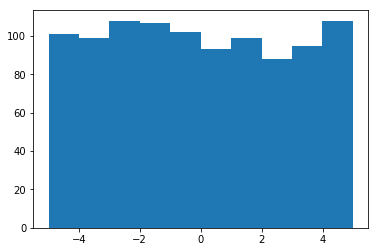

In [0]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_kaleness_exposure)
_ = plt.hist(starting_nke)

## Response model

The next thing we want to check off our list is the user response class. RecSim will generate one response for every recommended item in the slate. The contents of the response are what the agent will see as document-specific feedback from the recommendation (the non-document specific feedback being generated in LTSUserState.create_observation).  

In [0]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

##User model

Now that we have a way to generate users for our sessions, need to specify the actual user behavior. A RecSim user model (deriving from recsim.user.AbstractUserModel) is responsible for 
* maintaining user state, 
* evolving user state as a result of recommendations,
* generating a response to a slate of recommendations.

To this end, our user model is required by the base class to implement update_state() and simulate_response(), as well as is_terminal, which indicates when the end of the session occurs. This is facilitated by decreasing *self.time_budget* on every step.To make presentation clearer, we will define each function separately, and then assemble them into a class.



Our init is simple---we just pass the response_model constructor, user sampler and slate size down to the AbstractUserModel base class. Exploring other environments, the reader might notice that user model __init__ functions do offer a lot of flexibility for configuring the simulation. For now, however, we stick to the basics and hardcode things.

In [0]:
def user_init(self,
              slate_size,
              seed=0):

  super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
  self.choice_model = MultinomialLogitChoiceModel({})

The simulate_response() method takes in a slate (list) of recommended (i.e., produced by the agent) LTSDocuments and must output a slate of user responses. The *k*-th response in the slate of responses corresponds to the *k*-th document in the recommendation slate. In this case, we pick one document to click on based on our choice model, and produce an engagement value. We will let the responses to the unclicked documents be vacuous, however, one might use them in more subtle ways (e.g., recording whether the user inspected that document, etc.).  

In [0]:
def simulate_response(self, slate_documents):
  # List of empty responses
  responses = [self._response_model_ctor() for _ in slate_documents]
  # Get click from of choice model.
  self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
  scores = self.choice_model.scores
  selected_index = self.choice_model.choose_item()
  # Populate clicked item.
  self._generate_response(slate_documents[selected_index],
                          responses[selected_index])
  return responses

def generate_response(self, doc, response):
  response.clicked = True
  # linear interpolation between choc and kale.
  engagement_loc = (doc.kaleness * self._user_state.choc_mean
                    + (1 - doc.kaleness) * self._user_state.kale_mean)
  engagement_loc *= self._user_state.satisfaction
  engagement_scale = (doc.kaleness * self._user_state.choc_stddev
                      + ((1 - doc.kaleness)
                          * self._user_state.kale_stddev))
  log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)
  response.engagement = np.exp(log_engagement)

The update_state() method implements our state transition kernel. It consumes the recommended slate, as well as the actual choices (responses) to induce a state transition. The state is modified in-place, so the function does not return anything.

In [0]:
def update_state(self, slate_documents, responses):
  for doc, response in zip(slate_documents, responses):
    if response.clicked:
      innovation = np.random.normal(scale=self._user_state.innovation_stddev)
      net_kaleness_exposure = (self._user_state.memory_discount
                                * self._user_state.net_kaleness_exposure
                                - 2.0 * (doc.kaleness - 0.5)
                                + innovation
                              )
      self._user_state.net_kaleness_exposure = net_kaleness_exposure
      satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                        * net_kaleness_exposure)
                          )
      self._user_state.satisfaction = satisfaction
      self._user_state.time_budget -= 1
      return

Finally, the session expires when the time budget goes to 0.

In [0]:
def is_terminal(self):
  """Returns a boolean indicating if the session is over."""
  return self._user_state.time_budget <= 0


We have all the components to instantiate a user model, so let's wrap them up in a class.

In [0]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

Finally, we assemble all components into an Environment.

In [0]:
 slate_size = 3
 num_candidates = 10
 ltsenv = environment.Environment(
            LTSUserModel(slate_size),
            LTSDocumentSampler(),
            num_candidates,
            slate_size,
            resample_documents=True)


## Recap
Before we conclude, let's take a second to recap everything we've done so far. The diagram below maps all the classes we've implemented/imported from RecSim to the functional diagram of RecSim.
![RecSim implementation](https://github.com/google-research/recsim/blob/master/recsim/colab/figures/simulator_implemented.png?raw=true)



## Interacting with an agent

We now have a fully implemented environment in hand. In order to train/evaluate agents in this environment, we first need to specify a reward function. In RecSim, a reward function maps a set of responses to a real number. Suppose we want to maximize the engagement of the clicked documents.  

In [0]:
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    if response.clicked:
      reward += response.engagement
  return reward

Now, we simply use the OpenAI gym wrapper, which essentially provides a familiar step-based API.

In [0]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [0]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
doc_id 10 kaleness [0.79172504]
doc_id 11 kaleness [0.52889492]
doc_id 12 kaleness [0.56804456]
doc_id 13 kaleness [0.92559664]
doc_id 14 kaleness [0.07103606]
doc_id 15 kaleness [0.0871293]
doc_id 16 kaleness [0.0202184]
doc_id 17 kaleness [0.83261985]
doc_id 18 kaleness [0.77815675]
doc_id 19 kaleness [0.87001215]
Noisy user state observation
[0.41857747]
Observation 1
Available documents
doc_id 20 kaleness [0.97861834]
doc_id 21 kaleness [0.79915856]
doc_id 22 kaleness [0.46147936]
doc_id 23 kaleness [0.78052918]
doc_id 24 kaleness [0.11827443]
doc_id 25 kaleness [0.63992102]
doc_id 26 kaleness [0.14335329]
doc_id 27 kaleness [0.94466892]
doc_id 28 kaleness [0.52184832]
doc_id 29 kaleness [0.41466194]
User responses to documents in the slate
{'click': 0, 'engagement': 0.0}
{'click': 0, 'engagement': 0.0}
{'click': 1, 'engagement': 16.002030934389694}
Noisy user state observation
[0.47885928]
